In [261]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.inspection import permutation_importance

In [262]:
df = pd.read_csv('../../data/processed/realestates_kh_encode_v1.csv')  

In [263]:
X = df.drop(['price'], axis=1)
y = df['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
)

In [265]:
print("Max value in X_train:", X_train.max().max())
print("Max value in X_test:", X_test.max().max())
print("Max value in y_train:", y_train.max())
print("Max value in y_test:", y_test.max())


Max value in X_train: 104635
Max value in X_test: 28799
Max value in y_train: 276264450
Max value in y_test: 4500000


In [266]:
linear_model = LinearRegression()

In [267]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=63,
    learning_rate=0.05,
    n_estimators=1000,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1  # Silence LightGBM output
)

In [268]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [269]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

In [270]:
stacked_model = StackingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=KFold(n_splits=3, shuffle=True, random_state=42)
)

In [271]:
models = {
    "Linear Regression": linear_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Stacked Ensemble": stacked_model
}

In [272]:
def train_and_evaluate(model, model_name, X_train, X_test, 
                       y_train_scaled, y_test_scaled, 
                       y_scaler, y_train_orig, y_test_orig):
    """Train model and evaluate performance with scaled targets"""
    print(f"\nTraining {model_name}...")
    
    # Train model on SCALED targets
    model.fit(X_train, y_train_scaled)
    
    # Make predictions (returns scaled predictions)
    train_preds_scaled = model.predict(X_train)
    test_preds_scaled = model.predict(X_test)
    
    # Convert predictions back to original scale
    train_preds_orig = y_scaler.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
    test_preds_orig = y_scaler.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
    
    # Calculate metrics using ORIGINAL targets
    train_mae = mean_absolute_error(y_train_orig, train_preds_orig)
    test_mae = mean_absolute_error(y_test_orig, test_preds_orig)
    test_r2 = r2_score(y_test_orig, test_preds_orig)
    test_median_error = np.median(np.abs(y_test_orig - test_preds_orig) / y_test_orig) * 100
    
    # Create predictions comparison dataframe
    results_df = pd.DataFrame({
        'Actual': y_test_orig,
        'Predicted': test_preds_orig,
        'Error': y_test_orig - test_preds_orig,
        'Pct_Error': (y_test_orig - test_preds_orig) / y_test_orig * 100
    })
    
    return {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_median_error': test_median_error,
        'results_df': results_df
    }

In [273]:
from sklearn.preprocessing import StandardScaler

# 1. Scale the target variable (y)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.to_numpy().reshape(-1, 1)).flatten()
# 2. Run training with scaled targets AND pass the scaler
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate(
        model, name, 
        X_train, X_test, 
        y_train_scaled, y_test_scaled,
        y_scaler,  # MUST pass the scaler to invert predictions
        y_train, y_test  # Pass original targets for evaluation
    )


Training Linear Regression...



Training LightGBM...

Training XGBoost...

Training Random Forest...

Training Stacked Ensemble...


In [274]:
best_model_name = min(results, key=lambda k: results[k]['test_mae'])
best_results = results[best_model_name]['results_df']


In [275]:
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[name]['train_mae'] for name in results],
    'Test MAE': [results[name]['test_mae'] for name in results],
    'Test R²': [results[name]['test_r2'] for name in results],
    'Median Error %': [results[name]['test_median_error'] for name in results]
})
performance_df['Train MAE'] = performance_df['Train MAE'].apply(lambda x: f"${x:,.0f}")
performance_df['Test MAE'] = performance_df['Test MAE'].apply(lambda x: f"${x:,.0f}")
performance_df['Test R²'] = performance_df['Test R²'].apply(lambda x: f"{x:.3f}")
performance_df['Median Error %'] = performance_df['Median Error %'].apply(lambda x: f"{x:.1f}%")

print("Model Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,Model,Train MAE,Test MAE,Test R²,Median Error %
0,Linear Regression,"$1,259,955","$1,439,059",-7.380,194.3%
1,LightGBM,"$170,028","$206,024",0.582,18.8%
2,XGBoost,"$3,153","$28,661",0.994,4.0%
3,Random Forest,"$123,794","$15,197",0.999,3.8%
4,Stacked Ensemble,"$203,343","$121,649",0.948,31.8%


C:\Users\User\AppData\Local\Temp\ipykernel_23884\4129804107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\User\AppData\Local\Temp\ipykernel_23884\4129804107.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


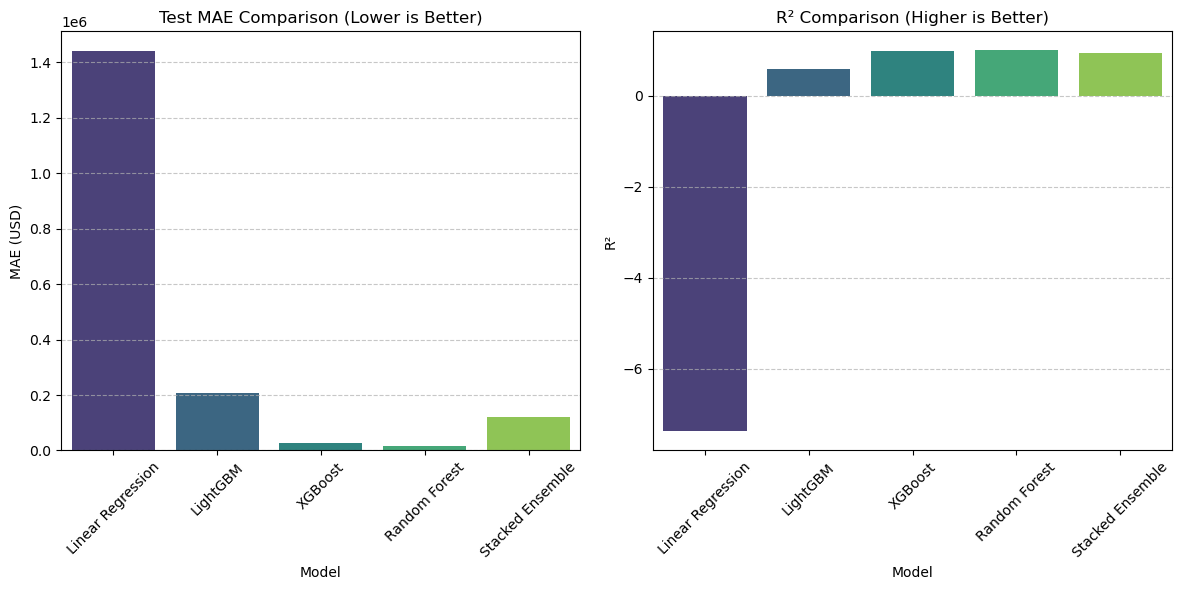

In [276]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(
    x='Model', 
    y=[results[name]['test_mae'] for name in results], 
    data=performance_df,
    palette='viridis'
)
plt.title('Test MAE Comparison (Lower is Better)')
plt.ylabel('MAE (USD)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
sns.barplot(
    x='Model', 
    y=[results[name]['test_r2'] for name in results], 
    data=performance_df,
    palette='viridis'
)

plt.title('R² Comparison (Higher is Better)')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

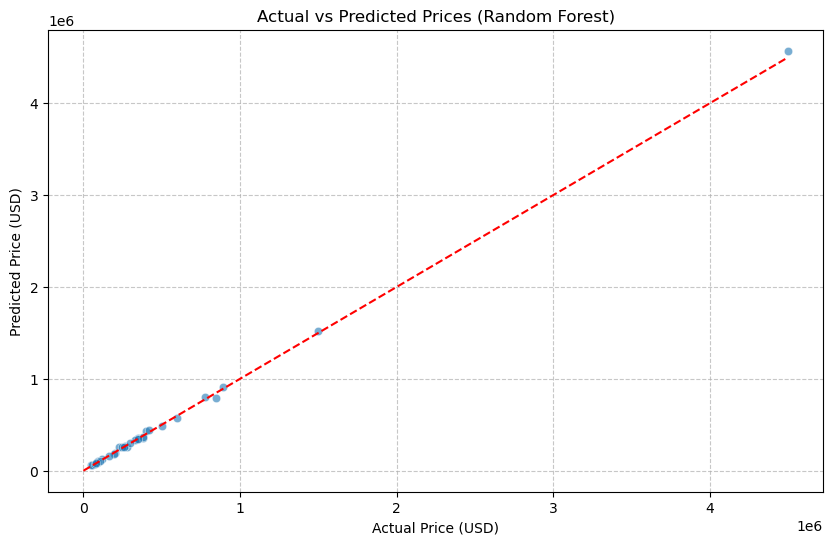

In [277]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Actual', 
    y='Predicted', 
    data=best_results,
    alpha=0.6
)
plt.plot([0, best_results['Actual'].max()], [0, best_results['Actual'].max()], 'r--')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.xlabel('Actual Price (USD)')
plt.ylabel('Predicted Price (USD)')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

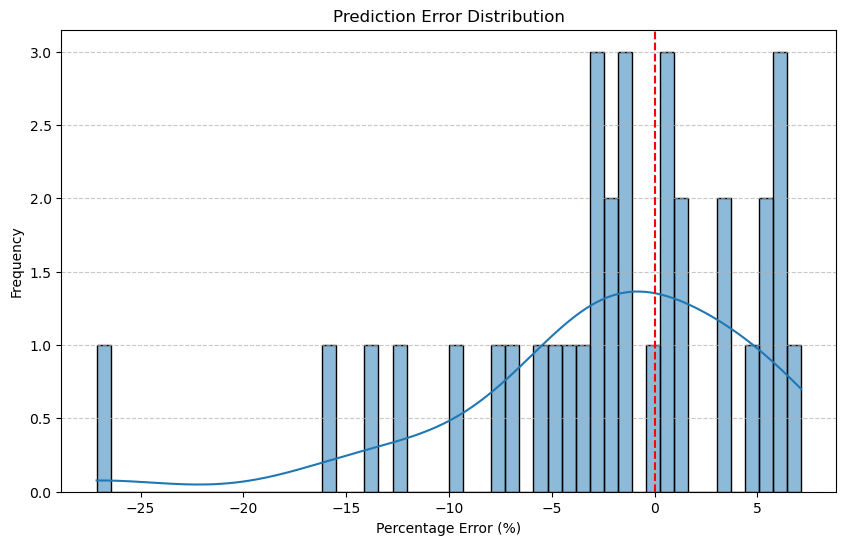

In [278]:
plt.figure(figsize=(10, 6))
sns.histplot(best_results['Pct_Error'], bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.axvline(0, color='r', linestyle='--')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_23884\1478223832.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


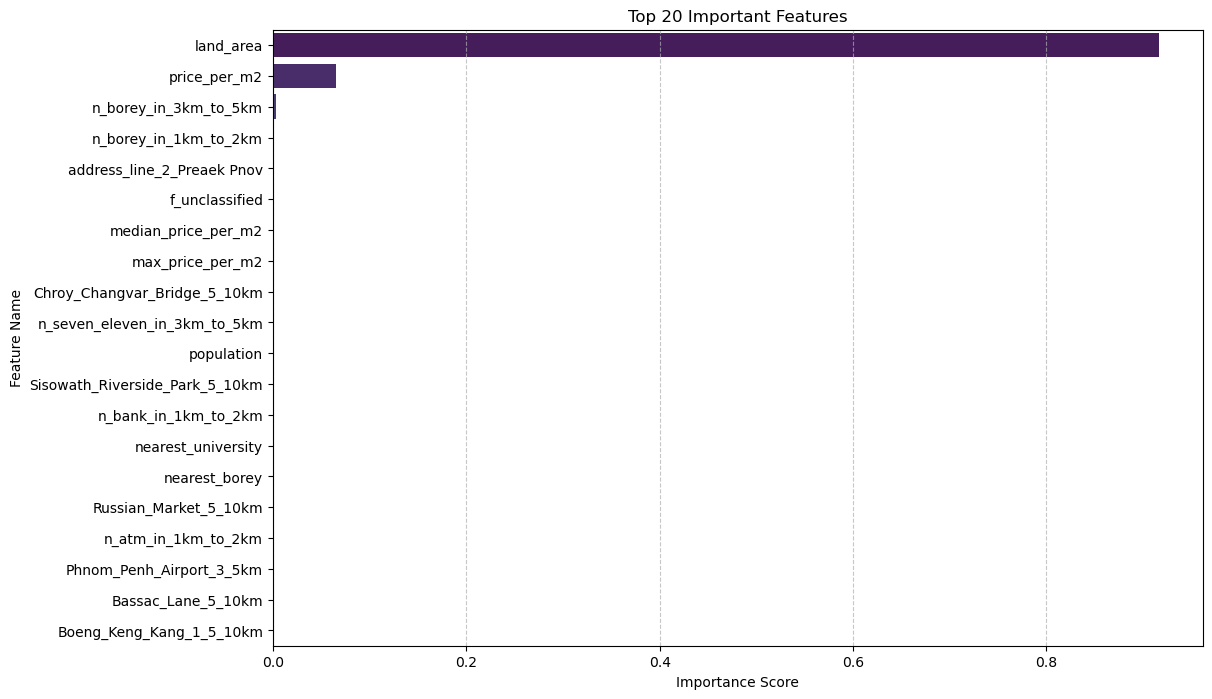

In [279]:
best_model = results[best_model_name]['model']

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X_train.columns
elif hasattr(best_model, 'coef_'):
    importances = np.abs(best_model.coef_)
    feature_names = X_train.columns
else:
    result = permutation_importance(
        best_model, X_test, y_test, n_repeats=10, random_state=42
    )
    importances = result.importances_mean
    feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df,
    palette='viridis'
)
plt.title('Top 20 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()
